# Garbage Classification with PyTorch
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1" alt="Garbage Bins" height="300"/>

In this notebook we will implement different ResNet’s with the goal of comparing the models to find the 'best' for our classifier.

We are seeking to understand which ResNet configurations are most effective for classifying images of garbage. This type of modeling could be used for automated garbage sorting etc.

In [22]:
from pathlib import Path
import urllib.request
import zipfile
import os
import time
import random
import io
import gdown

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pickle

import torch
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from torchvision.models import resnet18, ResNet18_Weights, \
                               resnet34, ResNet34_Weights, \
                               resnet50, ResNet50_Weights, \
                               resnet101, ResNet101_Weights, \
                               resnet152, ResNet152_Weights

from PIL import Image

### Download Data

In [23]:
url = 'https://drive.google.com/uc?id=1z3AmVOFOM6TdXaC5tvcyGJyPsfDfEcI5'
outfile = "data.zip"

if not os.path.exists("data"):
    gdown.download(url, outfile, quiet=False)

    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()
    os.remove("data.zip")

### Data Preparation

**The Garbage Classification Dataset contains 6 classifications:** 
* cardboard (393) 
* glass (491) 
* metal (400) 
* paper (584)
* plastic (472)
* trash(127)

In [24]:
# collect directory
data_dir = Path('data/Garbage classification')
transformer = T.Compose([T.Resize((256, 256)), T.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformer)

# display class names
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


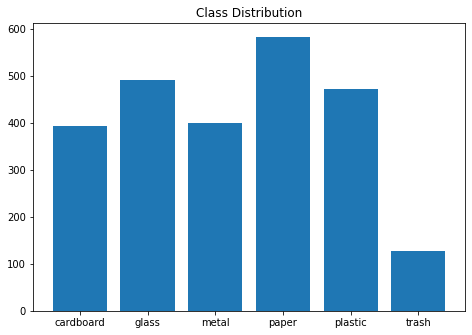

In [25]:
# display class distribution
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [393,491,400,584,472,127]
ax.bar(dataset.classes,counts)
plt.title('Class Distribution')
plt.show()

### Split Data

In [26]:
def split(length) -> tuple:
    '''return split lengths'''
    # r = .15 # 70/15/15
    # r = .10 # 80/10/10
    r = .05 # 90/5/5
    test_val = int(round(length*r,0))
    train = int(round(length-test_val*2,0))
    return (train,test_val,test_val)

In [27]:
# randomly split the dataset into non-overlapping new datasets of given lengths - (90-5-5) in this case
train, test, val = random_split(dataset, split(len(dataset)), generator=torch.Generator().manual_seed(42))
print(f'split lengths: {(len(train),len(test),len(val))}') # split check

# define batch size & data loader
batch_size = 16
train_dl = DataLoader(dataset = train, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory = True)
test_dl = DataLoader(dataset = test, batch_size = batch_size, num_workers=4, pin_memory = True)
val_dl = DataLoader(dataset = val, batch_size = batch_size, num_workers=4, pin_memory = True)

split lengths: (2275, 126, 126)


### Transfer DataLoaders to GPU

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device # MSI GAMING X TRIO GeForce RTX 3070 Ti

device(type='cuda')

In [29]:
def to_device(data, device):
    """move tensor(s) to current device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [30]:
class DeviceDataLoader():
    """wrap dataloader, then transfer to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """yield a batch of data after moving it to device"""
        for batch in self.dl: 
            yield to_device(batch, self.device)

    def __len__(self):
        """number of batches"""
        return len(self.dl)

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Preview Data

In [32]:
# helper function to display a specific sample
def show_sample(image, label):
    '''displays single image'''
    fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    print(f'Label: {dataset.classes[label]} (Class No: {str(label)})')
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

In [33]:
# helper function to display batches
def show_batch(dl):
    '''displays image batches from the DataLoader'''
    fig, ax = plt.subplots(figsize=(15, 10))
    for images, labels in dl:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images.cpu(), nrow = batch_size//2).permute(1, 2, 0))
        break

Label: cardboard (Class No: 0)


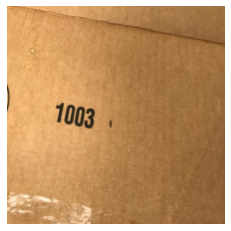

In [34]:
# select random sample to display
sample = int(np.random.randint(len(dataset)-1, size=1))
img, label = dataset[sample]

show_sample(img, label)

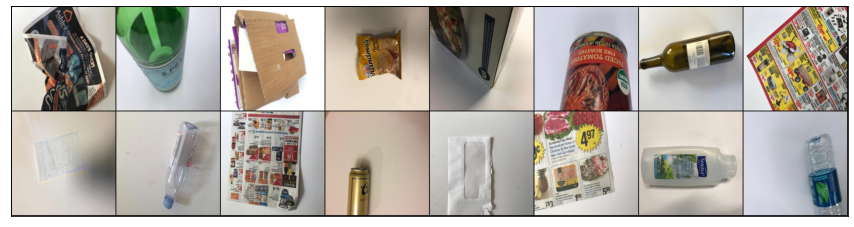

In [35]:
show_batch(train_dl)

### Define Base Model

In [36]:
# define base image classification class object
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.history = None
        self.maxAcc = None
        self.evalAcc = None

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # generate predictions -training
        loss = F.cross_entropy(out, labels) # calculate loss (gradient) - criterion
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # generate predictions - validation
        loss = F.cross_entropy(out, labels)   # calculate loss (gradient) - criterion
        acc = accuracy(out, labels)           # calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        # TO-DO: add time per epoch
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

### Initialize ResNet Models

In [37]:
# define resnet model and init pretrained weights & attributes
class ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # use a pretrained model
        num_ftrs = self.network.fc.in_features # collect number of features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) # replace last layer

        self.name = 'ResNet18'

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [38]:
class ResNet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1) # use a pretrained model
        num_ftrs = self.network.fc.in_features # collect number of features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) # replace last layer

        self.name = 'ResNet34'
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [39]:
class ResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1) # use a pretrained model
        num_ftrs = self.network.fc.in_features # collect number of features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) # replace last layer

        self.name = 'ResNet50'
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [40]:
class ResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1) # use a pretrained model
        num_ftrs = self.network.fc.in_features # collect number of features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) # replace last layer

        self.name = 'ResNet101'
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [41]:
class ResNet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1) # use a pretrained model
        num_ftrs = self.network.fc.in_features # collect number of features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) # replace last layer

        self.name = 'ResNet152'
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb)) # return batch

In [42]:
models = [ResNet18(),ResNet34(),ResNet50(),ResNet101(),ResNet152()] # collect init models
# models = [ResNet18(),ResNet34()] # TEST
model_names = [model.name for model in models]

### Define Model Fit & Eval Steps

In [43]:
@torch.no_grad() # define no gradient decorator for evaluation method
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader] # collect outputs for each batch
    return model.validation_epoch_end(outputs) # send full output to epoch end model function

def fit(epochs, model, train_loader, val_loader, optimizer):
    history = []
    for epoch in range(epochs):
        # training phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step() 
            optimizer.zero_grad() # do not compute gradient on batch
        # validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # TO-DO: add time per epoch to history
    return history

### Find Best ResNet Model

In [44]:
# collect best model from model list
def bestModel(models):
    best_model = max([sum((model.maxAcc,model.evalAcc)) for model in models]) # combined maxAcc and evalAcc
    return [model for model in models if sum((model.maxAcc,model.evalAcc)) == best_model][0]

In [45]:
def ResNetSearch(epochs, lr, models, train_loader, val_loader):
    result_models = [] # init model list
    safety_sleep = 15 # init device cool off timer
    for model in models:
        print(model.name)
        model = to_device(model, device) # send model to current device
        optimizer = torch.optim.Adam(model.parameters(), lr=lr) # init model optimizer 
        history = fit(epochs, model, train_loader, val_loader, optimizer) # fit current model
        model.history = pd.DataFrame(history,columns=['train_loss', 'val_loss', 'val_acc']) # store history in model object
        model.maxAcc = max([x['val_acc'] for x in history]) # store maxAcc in model object
        model.evalAcc = evaluate(model, test_dl)['val_acc'] # store evalAcc in model object
        result_models.append(model) # append trained model to model list
        if model.name != model_names[-1]: # do not sleep for last model
            print(f'sleeping {safety_sleep} seconds')
            time.sleep(safety_sleep) # apply device cool off timer
            safety_sleep += 5 # step device cool off timer
    best_model = bestModel(result_models) # select best model
    return best_model,result_models

In [46]:
# # define learning rate and number of epochs, then run all ResNet models collecting all trained models and a best model
# num_epochs = 8
# lr = 5.5e-5

# best_model,result_models = ResNetSearch(num_epochs, lr, models, train_dl, val_dl) # 23m 20.7s

### Save Models

In [47]:
# collect model names & define model directory
# model_names = [model.name for model in result_models]
model_dir = Path('data/models')

In [48]:
# # save pickle file for each model
# for i in range(len(model_names)):
#     file = open(os.path.join(model_dir,f'{model_names[i]}.pkl'), 'wb')
#     pickle.dump(result_models[i], file)
#     file.close()

### Load Models

In [49]:
# define class to unpickle on current device (CPU or GPU), independent of which device the model was trained on.
class DeviceUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

In [50]:
# load pickle file for each model
loaded_models = []
for i in range(len(model_names)):
    file = open(os.path.join(model_dir,f'{model_names[i]}.pkl'), 'rb')
    loaded_models.append(DeviceUnpickler(file).load())
    file.close()

# re-select best model since we are not training
best_model = bestModel(loaded_models)

### Plot Best Model Accuracy & Loss

In [51]:
best_model.name

'ResNet101'

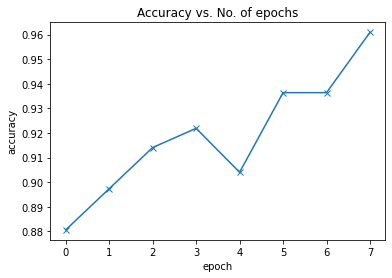

In [52]:
def plot_accuracies(history):
    accuracies = [acc for acc in history['val_acc']]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(best_model.history)

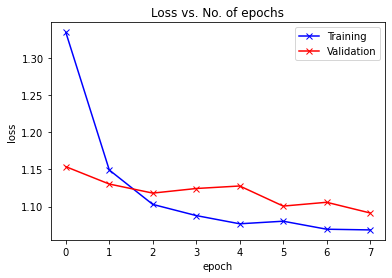

In [53]:
def plot_losses(history):
    train_losses = [x for x in history['train_loss']]
    val_losses = [x for x in history['val_loss']]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(best_model.history)

In [54]:
# collect accuracies for each model
maxAccs = [model.maxAcc for model in loaded_models]
evalAccs = [model.evalAcc for model in loaded_models]

acc_df = pd.DataFrame(zip(maxAccs,evalAccs),columns=['maxAcc','evalAcc'],index=model_names)
acc_df['model_score'] = acc_df['maxAcc'] + acc_df['evalAcc']
acc_df

,maxAcc,evalAcc,model_score
ResNet18,0.944196,0.936384,1.880580
ResNet34,0.960938,0.912946,1.873884
ResNet50,0.953125,0.921875,1.875000
ResNet101,0.960938,0.959821,1.920759
ResNet152,0.952009,0.921875,1.873884


**Note:** 

ResNet34 and ResNet101 have nearly identical max accuracies but ResNet34's evaluation accuracy is approx. 4% lower than ResNet101. This results in a higher model score for ResNet101, thus we should select model as the best model.

### Plot Model Accuracy Comparison

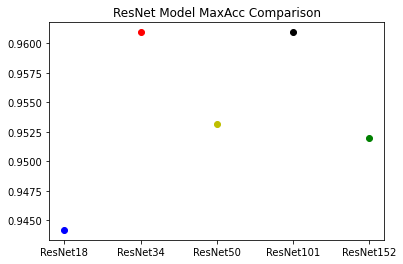

In [55]:
# display model maxAcc on plot
def plot_model_compare(accuracies):
    colors = ['k','b','y','g','r']
    n = len(model_names)
    
    for x, y, c in zip(accuracies.index, accuracies['maxAcc'], random.sample(colors, n)):
        plt.scatter(x, y, color=c)
    plt.title('ResNet Model MaxAcc Comparison')

plot_model_compare(acc_df)

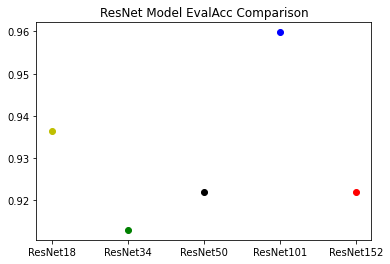

In [56]:
# display model evalAcc on plot
def plot_model_compare(accuracies):
    colors = ['k','b','y','g','r']
    n = len(model_names)
    
    for x, y, c in zip(accuracies.index, accuracies['evalAcc'], random.sample(colors, n)):
        plt.scatter(x, y, color=c)
    plt.title('ResNet Model EvalAcc Comparison')

plot_model_compare(acc_df)

### Display Predictions

In [57]:
# helper function to predict on dataloader images
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device) # convert to a batch of 1
    yb = model(xb) # get predictions from model
    prob, preds  = torch.max(yb, dim=1) # select index with highest probability
    return dataset.classes[preds[0].item()] # retrieve the class label

Label: metal , Predicted: metal


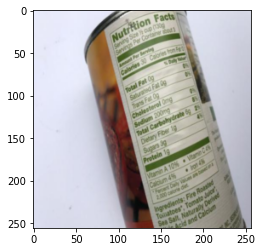

In [58]:
img, label = test[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, best_model))

Label: plastic , Predicted: plastic


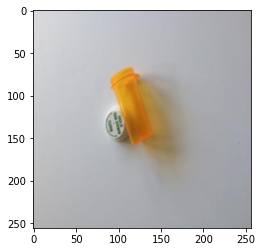

In [59]:
img, label = test[24]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, best_model))

Label: cardboard , Predicted: cardboard


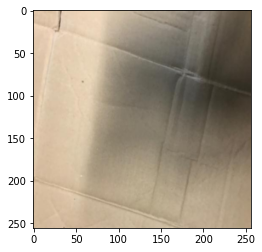

In [60]:
img, label = test[60]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, best_model))

### Predict External Images

In [61]:
# define external image directory
img_dir = Path('data/imgs')

# define a external image path for each class
cardboard = os.path.join(img_dir, 'cardboard.jpg')
glass = os.path.join(img_dir, 'glass.jpg')
metal = os.path.join(img_dir, 'metal.jpg')
paper = os.path.join(img_dir, 'paper.jpg')
plastic = os.path.join(img_dir, 'plastic.jpg')
trash = os.path.join(img_dir, 'trash.jpg')

# download images if they don't exist
if not os.path.exists(cardboard): 
    urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fi.ebayimg.com%2Fimages%2Fi%2F291536274730-0-1%2Fs-l1000.jpg&f=1&nofb=1", cardboard)
if not os.path.exists(glass):
    urllib.request.urlretrieve("https://cdn.shopify.com/s/files/1/0669/3891/products/acc23b05-e02d-4a82-a113-5640d0fa634d_384x384.jpg?v=1634788809", glass)  
if not os.path.exists(metal):
    urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", metal)  
if not os.path.exists(paper):
    urllib.request.urlretrieve("https://cdn.shopify.com/s/files/1/1722/0531/products/new-york-times-back-copies_1024x1024.jpg?v=1642632958", paper)
if not os.path.exists(plastic):
    urllib.request.urlretrieve("https://discovery.sndimg.com/content/dam/images/discovery/fullset/2022/1/24/GettyImages-1325351577.jpg.rend.hgtvcom.406.406.suffix/1643047005309.jpeg", plastic)
if not os.path.exists(trash):
    urllib.request.urlretrieve("https://livermorerecycles.org/wp-content/uploads/2018/04/bar-wrapper.jpg", trash)

In [62]:
# helper function to predict on external images
def predict_external_image(img_path):
    image = Image.open(img_path)
    example_image = transformer(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, best_model) + ".")

The image resembles cardboard.


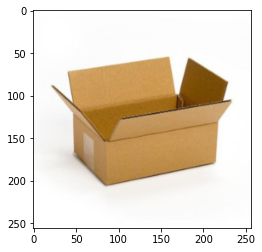

In [63]:
predict_external_image(cardboard)

The image resembles metal.


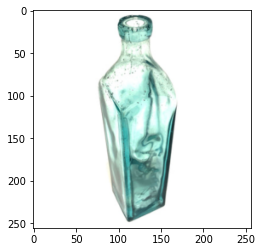

In [64]:
predict_external_image(glass)

The image resembles metal.


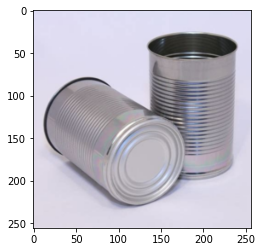

In [65]:
predict_external_image(metal)

The image resembles paper.


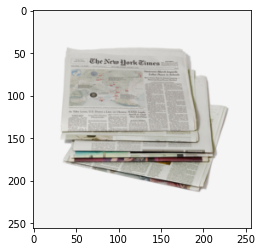

In [66]:
predict_external_image(paper)

The image resembles paper.


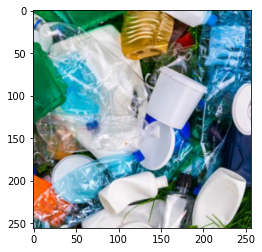

In [67]:
predict_external_image(plastic)

The image resembles metal.


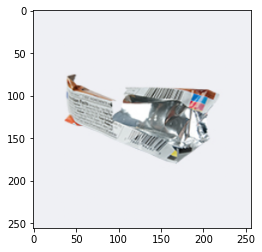

In [68]:
predict_external_image(trash)

### Conclusion

Overall ResNet's are relatively straightforward to set up and compare given the complexity of image classification. Understanding more about learning rates and other tuning methods certainly needs more diving into, there is so much more to learn!

For reference, a good list of models and accuracies sit in pytorch’s docs: https://pytorch.org/vision/main/models.html waiting to be explored.

In summary, comparing ResNet models with an adam optimizer 8 epochs and a learning rate of 5.5e-5 for classification of garbage types yields a max model accuracy of 96% for the ResNet101 pretrained model. We should consider retraining the ResNet101 model with more epochs to locate where the accuracy fall off begins.